In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic
from schemdraw import dsp

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

import json
from IPython.display import display, HTML
from IPython.display import Javascript

display(HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.5.0/chart.min.js" integrity="sha512-asxKqQghC1oBShyhiBwA+YgotaSYKxGP1rcSYTDrB0U6DxwlJjU59B67U8+5/++uFjcuVM8Hh5cokLjZlhm3Vg==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
'''))

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ;
    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__name__ = name
        self.__R = R
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        self.R1.resistance = self.__R * w
        self.R2.resistance = self.__R * (1.0-w)
        

# *about*

A state variable filter is constructed with two integrator amplifier and a summer. The integrators are low bass filters. The output of both is mixed back to the input. This will give three resonses. A High pass, band pass and low pass response. 

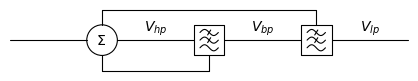

In [3]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.1)

#first muliplication
d += (elm.Line())
d += ( sum := dsp.SumSigma())
d += (elm.Line().label('$V_{hp}$'))
d += (bp := dsp.Filter(response='lp'))
d += (elm.Line().label('$V_{bp}$'))
d += (lp := dsp.Filter(response='lp'))
d += (elm.Line().label('$V_{lp}$'))

d += elm.Line().up().at(lp.N).length(0.5)
d += elm.Line().left().tox(sum.N)
d += elm.Line().down().toy(sum.N)

d += elm.Line().down().at(bp.S).length(0.5)
d += elm.Line().left().tox(sum.S)
d += elm.Line().up().toy(sum.S)

d.draw()




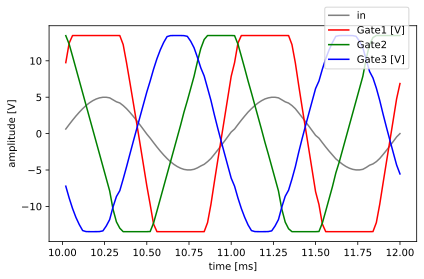

/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:46: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, phase, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/

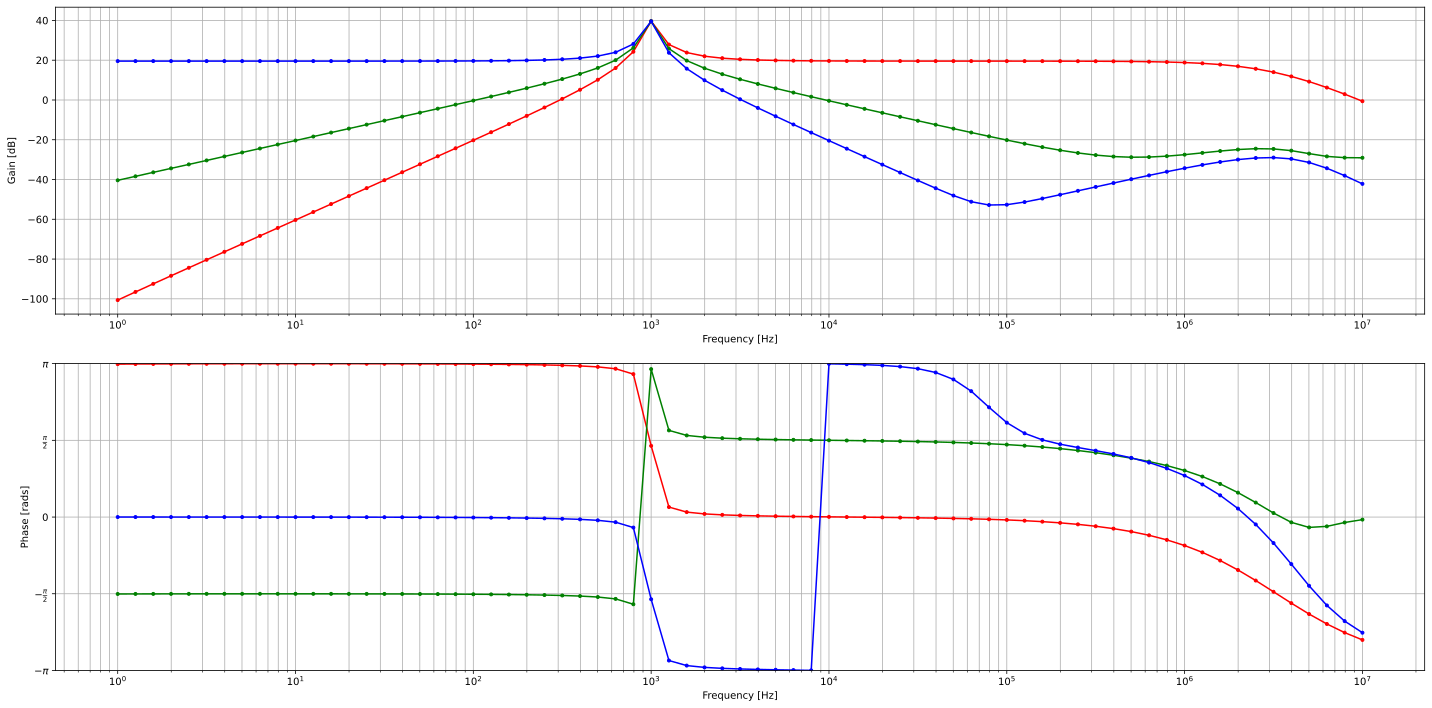

In [4]:
circuit = Circuit('svf')
circuit.include(spice_library['TL072'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('3', '-15V', circuit.gnd, 'DC -15')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 1k)')

circuit.X('1', 'TL072', 'gate_in_1p', 'gate_in_1', '+15V','-15V', 'gate_out_1')
circuit.X('2', 'TL072', circuit.gnd, 'gate_in_2', '+15V','-15V', 'gate_out_2')
circuit.X('3', 'TL072', circuit.gnd, 'gate_in_3', '+15V','-15V', 'gate_out_3')

circuit.R(1, 'IN', 'gate_in_1p', 1@u_kΩ)
circuit.R(2, 'gate_out_2', 'gate_in_1p', 19@u_kΩ)
circuit.R(3, 'gate_out_1', 'gate_in_1', 10@u_kΩ)
circuit.R(4, 'gate_out_3', 'gate_in_1', 10@u_kΩ)

circuit.R(5, 'gate_out_1', 'gate_in_2', 16@u_kΩ)
circuit.R(6, 'gate_out_2', 'gate_in_3', 16@u_kΩ)

circuit.C(1, 'gate_in_2', 'gate_out_2', 10@u_nF)
circuit.C(2, 'gate_in_3', 'gate_out_3', 10@u_nF)


################################################################
# run the simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=10@u_MHz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)

################################################################
# draw signals
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
#ax1_buffer.plot(u_ms(analysis['Vin'].abscissa), analysis['Vin'], color='Grey')
ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Grey')
ax1_buffer.plot(u_ms(analysis['gate_out_1'].abscissa), analysis['gate_out_1'], color='Red')
ax1_buffer.plot(u_ms(analysis['gate_out_2'].abscissa), analysis['gate_out_2'], color='Green')
ax1_buffer.plot(u_ms(analysis['gate_out_3'].abscissa), analysis['gate_out_3'], color='Blue')

ax1_buffer.legend(('in', 'Gate1 [V]', 'Gate2', 'Gate3 [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()





################################################################
# draw bode diagram
from PySpice.Plot.BodeDiagram import bode_diagram
figure = plt.figure(1, (20, 10))
plt.title("Bode Diagram of a Low-Pass RC Filter")
axes = (plt.subplot(211), plt.subplot(212))
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.gate_out_1)),
             phase=np.angle(analysis_ac.gate_out_1, deg=False),
             marker='.',
             color='red',
             linestyle='-',
         )
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.gate_out_2)),
             phase=np.angle(analysis_ac.gate_out_2, deg=False),
             marker='.',
             color='green',
             linestyle='-',
         )
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.gate_out_3)),
             phase=np.angle(analysis_ac.gate_out_3, deg=False),
             marker='.',
             color='blue',
             linestyle='-',
         )


#for axe in axes:
#    axe.axvline(x=break_frequency, color='red')

plt.tight_layout()
plt.show()

# cmos svf


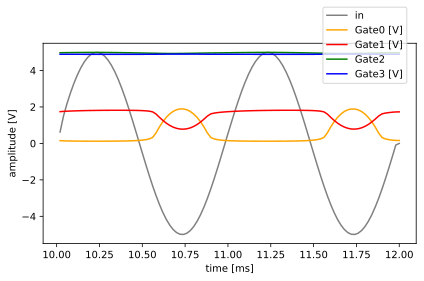

/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:46: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, phase, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/

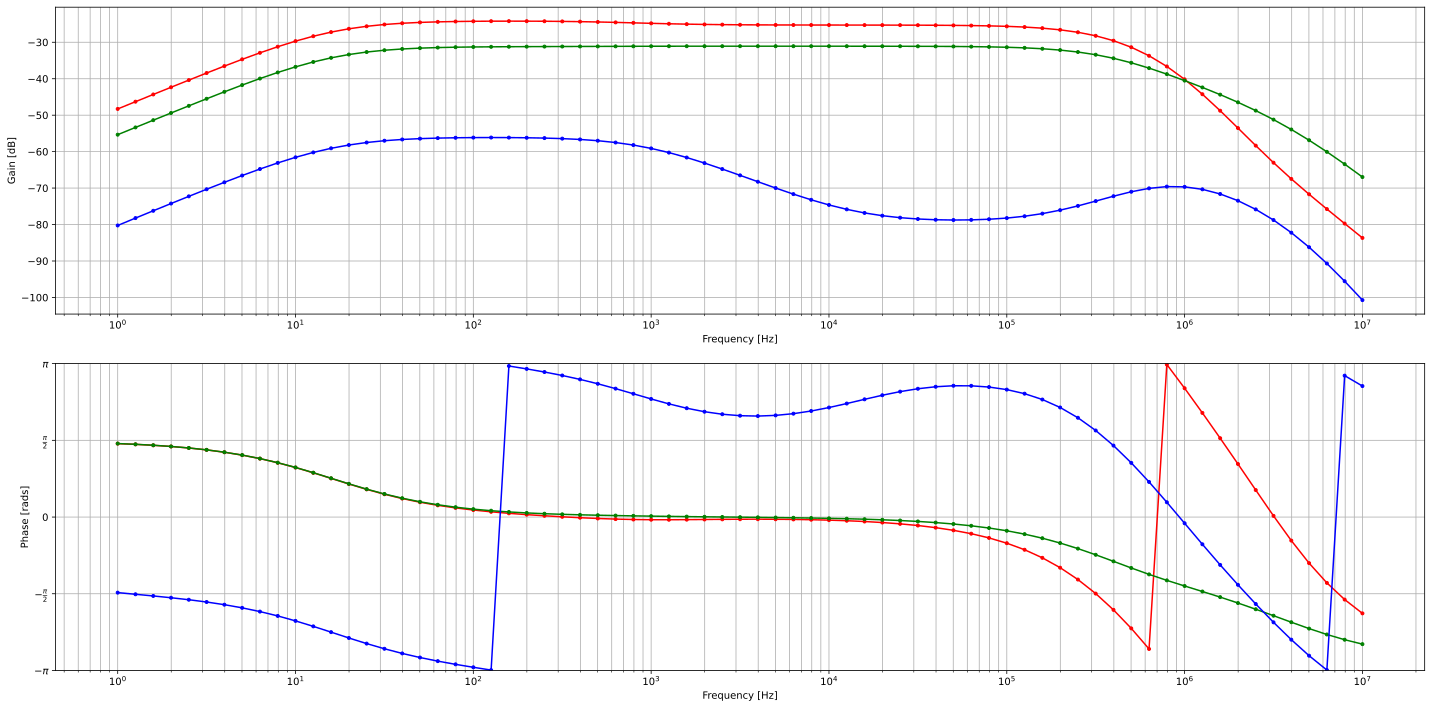

In [5]:
circuit = Circuit('svf')
circuit.include(spice_library['4069UB'])


circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 1k)')

circuit.X('0', '4069UB', 'gate_in_0', 'gate_out_0', '+5V', circuit.gnd)
circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.X('3', '4069UB', 'gate_in_3', 'gate_out_3', '+5V', circuit.gnd)

circuit.R(1, 'IN', 'R1', 33@u_kΩ)
circuit.C(0, 'R1', 'gate_in_0', 220@u_nF)
circuit.R(0, 'gate_in_0', 'gate_out_0', 33@u_kΩ)
circuit.R(10, 'gate_out_0', 'gate_in_1', 10@u_kΩ)
circuit.R(2, 'gate_out_2', 'gate_in_0', 19@u_kΩ)
circuit.R(3, 'gate_out_1', 'gate_in_1', 10@u_kΩ)
circuit.R(4, 'gate_out_3', 'gate_in_1', 10@u_kΩ)

circuit.C(5, 'gate_out_1', 'C5', 10@u_uF)
circuit.C(6, 'gate_out_2', 'C6', 10@u_uF)
circuit.R(20, 'C5', circuit.gnd, 100@u_kΩ)
circuit.R(21, 'C6', circuit.gnd, 100@u_kΩ)

circuit.R(5, 'C5', 'gate_in_2', 16@u_kΩ)
circuit.R(6, 'C6', 'gate_in_3', 16@u_kΩ)

circuit.C(1, 'gate_in_2', 'gate_out_2', 10@u_nF)
circuit.C(2, 'gate_in_3', 'gate_out_3', 10@u_nF)


################################################################
# run the simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=10@u_MHz, number_of_points=10,  variation='dec')
analysis  = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)

################################################################
# draw signals
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
#ax1_buffer.plot(u_ms(analysis['Vin'].abscissa), analysis['Vin'], color='Grey')
ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Grey')
ax1_buffer.plot(u_ms(analysis['gate_out_0'].abscissa), analysis['gate_out_0'], color='Orange')
ax1_buffer.plot(u_ms(analysis['gate_out_1'].abscissa), analysis['gate_out_1'], color='Red')
ax1_buffer.plot(u_ms(analysis['gate_out_2'].abscissa), analysis['gate_out_2'], color='Green')
ax1_buffer.plot(u_ms(analysis['gate_out_3'].abscissa), analysis['gate_out_3'], color='Blue')

ax1_buffer.legend(('in', 'Gate0 [V]', 'Gate1 [V]', 'Gate2', 'Gate3 [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

################################################################
# draw bode diagram
from PySpice.Plot.BodeDiagram import bode_diagram
figure = plt.figure(1, (20, 10))
plt.title("Bode Diagram of a Low-Pass RC Filter")
axes = (plt.subplot(211), plt.subplot(212))
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.gate_out_1)),
             phase=np.angle(analysis_ac.gate_out_1, deg=False),
             marker='.',
             color='red',
             linestyle='-',
         )
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.gate_out_2)),
             phase=np.angle(analysis_ac.gate_out_2, deg=False),
             marker='.',
             color='green',
             linestyle='-',
         )
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.gate_out_3)),
             phase=np.angle(analysis_ac.gate_out_3, deg=False),
             marker='.',
             color='blue',
             linestyle='-',
         )


#for axe in axes:
#    axe.axvline(x=break_frequency, color='red')

plt.tight_layout()
plt.show()

# Low-Pass filter


In [6]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.5, lw=0.7, fontsize=9, color='Red', fill="LightYellow")

d.add(elm.Dot('left', lftlabel='IN', open=True))
R1 = d.add(elm.Resistor(label='$R_1$\n100k'))
d.add(elm.Capacitor(label='$C_1$\n47n'))
N1 = d.add(logic.Not)
R2 = d.add(elm.Resistor(label='$R_3$\n100k'))
N2 = d.add(logic.Not)
R3 = d.add(elm.Resistor(label='$R_5$\n100k'))
N3 = d.add(logic.Not)
C = d.add(elm.Capacitor(label='$C_2$\n10u'))
d.add(elm.Resistor("down",label='$R_{load}$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$\n100k'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=N2.start))
d.add(elm.Line('up', l=d.unit/2))
d.push()
d.add(elm.Resistor('right', label='$R_4$\n100k'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())
d.pop()
d.add(logic.Dot())
d.add(elm.Line('up', l=d.unit))
d.add(elm.Capacitor('right', label='$C_4$\n10n'))
d.add(elm.Line('down', l=d.unit))
d.add(logic.Dot())

d.add(logic.Dot(xy=N3.start))
d.add(elm.Line('up', l=d.unit/2))
d.push()
d.add(elm.Resistor('right', label='$R_6$\n100k'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())
d.pop()
d.add(logic.Dot())
d.add(elm.Line('up', l=d.unit))
d.add(elm.Capacitor('right', label='$C_4$\n10n'))
d.add(elm.Line('down', l=d.unit))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Dot('right', rgtlabel='OUT', open=True))

d.add(elm.Line(at=C.start).down())
d.add(elm.Resistor(label='$R_4$\n100k').left().tox(N1.start))
d.add(elm.Line().up())

      
d.draw()

NameError: name 'logic' is not defined

The DOD is a very simple circuits that uses some overdive but mainly diode clipping. Such circuits are very common. There are variations in the tpes and wiring of the diodes. One example is the Batter Acid. 

In [ ]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')

circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.X('3', '4069UB', 'gate_in_3', 'gate_out_3', '+5V', circuit.gnd)

#input
circuit.R(1, 'IN', 'gate_in_1', 10@u_kΩ)
#circuit.C(1, 'R1', 'gate_in_1', 47@u_nF)

#connect the buffers
#circuit.C(10, 'gate_out_1', 'C10', 33@u_nF)
circuit.R(3, 'gate_out_1', 'gate_in_2', 20@u_kΩ)

#circuit.C(11, 'gate_out_2', 'C11', 33@u_nF)
circuit.R(5, 'gate_out_2', 'gate_in_3', 20@u_kΩ)

circuit.R(2, 'gate_in_1', 'gate_out_1', 10@u_kΩ)

#circuit.R(4, 'gate_in_2', 'gate_out_2', 100@u_kΩ)
circuit.C(3, 'gate_in_2', 'gate_out_2', 100@u_nF)

#circuit.R(6, 'gate_in_3', 'gate_out_3', 100@u_kΩ)
circuit.C(4, 'gate_in_3', 'gate_out_3', 100@u_nF)


circuit.R(0, 'gate_out_3', 'gate_in_1', 50@u_kΩ)


#circuit.C(2, 'gate_out', 'OUT', 1@u_uF)
#R = circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis  = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)
analysis_ac = simulator.ac(start_frequency=10@u_Hz, stop_frequency=20@u_kHz, number_of_points=10,  variation='dec')


In [ ]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 5V 1k)')

circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)
circuit.X('3', '4069UB', 'gate_in_3', 'gate_out_3', '+5V', circuit.gnd)

#input
circuit.R(1, 'IN', 'R1', 40@u_kΩ)
circuit.R(2, 'R1', 'R2', 100@u_kΩ)
circuit.C(1, 'R2', 'gate_in_1', 1@u_uF)
circuit.R(4, 'gate_in_1', 'gate_out_1', 100@u_kΩ)

#connect the buffers
circuit.R(3, 'gate_out_1', 'gate_in_2', 10@u_kΩ)
circuit.R(5, 'gate_out_2', 'gate_in_3', 10@u_kΩ)


circuit.C(3, 'gate_in_2', 'gate_out_2', 10@u_nF)
circuit.C(4, 'gate_in_3', 'gate_out_3', 10@u_nF)


circuit.R(0, 'gate_out_3', 'gate_in_1', 100@u_kΩ)


#circuit.C(2, 'gate_out', 'OUT', 1@u_uF)
#R = circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)
analysis_ac = simulator.ac(start_frequency=10@u_Hz, stop_frequency=20@u_kHz, number_of_points=10,  variation='dec')


In [ ]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
#ax1_buffer.plot(u_ms(analysis['Vin'].abscissa), analysis['Vin'], color='Grey')
ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Grey')
ax1_buffer.plot(u_ms(analysis['gate_out_1'].abscissa), analysis['gate_out_1'], color='Red')
ax1_buffer.plot(u_ms(analysis['gate_out_2'].abscissa), analysis['gate_out_2'], color='Green')
ax1_buffer.plot(u_ms(analysis['gate_out_3'].abscissa), analysis['gate_out_3'], color='Blue')

ax1_buffer.legend(('in', 'Gate1 [V]', 'Gate2', 'Gate3 [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

In [ ]:
from PySpice.Plot.BodeDiagram import bode_diagram
fig_buffer, axe = plt.subplots()

axe.semilogx(analysis_ac.frequency, 20*np.log10(np.absolute(analysis_ac.gate_out_2)), base=10)
axe.semilogx(analysis_ac.frequency, 20*np.log10(np.absolute(analysis_ac.gate_out_3)), base=10)
axe.grid(True)
axe.grid(True, which='minor')
axe.set_xlabel("Frequency [Hz]")
axe.set_ylabel("Gain [dB]")
    
#for axe in axes:
#    axe.axvline(x=break_frequency, color='red')

plt.tight_layout()
plt.show()

In [ ]:
buffer_data = []
for r in np.arange(1000, 100000, 1000) :
    circuit.R3.resistance = r
    circuit.R5.resistance = r
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_step = simulator.ac(start_frequency=10@u_Hz, stop_frequency=100@u_kHz, number_of_points=10,  variation='dec')
    buffer_data.append(20*np.log10(np.absolute(analysis_step.gate_out_3)).tolist())
    
print(len(buffer_data))

In [ ]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="Overdrive250Chart" class="400px"></canvas>
<input type="range" class="slider-width" id="Overdrive250Resistance" name="Overdrive250Resistance" min="0" max="98" value="0" step="1"></input>
<p class="content">Figure 3: Overdrive 250 Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
var Overdrive250Datas = %s;

const Overdrive250Data = {
  labels: %s,
    datasets: [
    {
      label: 'Output',
      data: Overdrive250Datas[0],
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var Overdrive250Ctx = document.getElementById('Overdrive250Chart').getContext('2d');
var Overdrive250Chart = new Chart(Overdrive250Ctx, {
    type: 'line',
    data: Overdrive250Data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: false,
                    text: '[ms]'
                },
/*                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                } */
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -1,
                max: 0,
                ticks: {
                    stepSize: 0.01
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

let Overdrive250Resistance = document.getElementById('Overdrive250Resistance');
Overdrive250Resistance.addEventListener('input', function (e) {
    Overdrive250Chart.data.datasets[0].data = Overdrive250Datas[Overdrive250Resistance.value];
    Overdrive250Chart.update();

});

''' % (json.dumps(buffer_data), analysis_ac.frequency.tolist() ) ))

The signal is nicely soft clipped. But it also has an offset. This offset comes from the uneven diode arrangement. 

## *Shin Ei FY-2*

In [ ]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.4, lw=0.7, fontsize=9)

d += (q1 := elm.BjtNpn(circle=True).at([5,0]).label('Q1'))

#draw opamp
d += elm.Line(at=q1.base).left().length(2)
d += elm.Dot()
d.push()
d += elm.Line().left().length(1)
d += elm.Capacitor().label('$v_{in}$', loc='lft').label('C1\n47n', loc='top')

d.pop()
d += elm.Line().up()
d += elm.Dot()
d.push()

d += elm.Resistor().right().tox(q1.collector).label('R1\n2.2M', loc='top')
d += elm.Dot()
d.pop()
d += elm.Line().up().length(2)
d += ( c2 := elm.Capacitor().right().tox(q1.collector).label('C2\n1n', loc='top') )
d += elm.Dot()

d += elm.Line().up().at(q1.collector).length(0.8)
d += elm.Dot()
d.push()
d += elm.Line().up().toy(c2.end)
d += ( r3 := elm.Resistor().label('R3\n22k', loc='bottom') )
d += elm.Dot()

d.pop()
d += elm.Line().length(2).right()
d += ( dot := elm.Dot() )
#d.push()
d += elm.Capacitor().label('C3\n47n', loc='top')
#d += elm.Line().length(1)
d += elm.Dot()
d.push()
d += elm.Line().length(1.75)
d += (q2 := elm.BjtNpn(circle=True).label('Q2'))

d.pop()
d += elm.Line().up()
d += elm.Resistor().right().label('R5\n1.2M', loc='top')
d += elm.Dot()
 
d += elm.Line().up().at(q2.collector).length(0.8)
d += elm.Dot()
d.push()

d += elm.Line().up().at(q2.collector).length(2)
d += elm.Resistor().label('R6\n47k', loc='top').toy(r3.end)
d += elm.Line().left()
d += elm.Dot()
d.push()
d += elm.Resistor().label('R4\n100k', loc='bottom')
d += elm.Dot()
d += elm.Line().length(4).label('+9V', loc='lft')

d.pop()
d += elm.Line().up().length(1)
d += elm.Capacitor().left().label('C4\n47n', loc='top')
d += elm.Line().down().length(1)

d.pop()
d += elm.Line().right()
d += elm.Capacitor().label('C5\n3.3n', loc='top')
d += ( rv1 := elm.Potentiometer().flip().label('RV1\n50k', loc='top') )
d += elm.Dot()
d.push()
d += elm.Capacitor().label('C6\n1n', loc='top')
d += elm.Dot()
d.push()
d += elm.Line().label('$V_{out}$', loc='rgt')

d.pop()
d += elm.Resistor().down().label('R8\n15k', loc='bottom')
d += elm.Line().left().length(1.25)
d += elm.Dot()
d.push()
d += elm.Line().left().length(1.25)

d.pop()
d += elm.Capacitor().down().label('C7\n100n', loc='top')
d += elm.Ground()

d.pop()
d += elm.Resistor().down().label('R7\n10k', loc='bottom')

d += elm.Ground().at(q1.emitter)
d += elm.Ground().at(q2.emitter)

d += elm.Line().at(rv1.tap).down().length(4)
d += elm.Line().left().length(5)
d += elm.Capacitor().label('C8\n2n', loc='top')
d += elm.Line().left().tox(dot.end)
d += elm.Line().up().toy(dot.end)

d.draw()

In [ ]:
circuit = Circuit('ShinEy')
circuit.include(spice_library['BC547B'])

circuit.V('1', '+9V', circuit.gnd, 'DC 9')
circuit.V('2', 'Vin', circuit.gnd, 'DC 0 Sine ( 0 800m 1k)')

# BJT =  nc nb ne
circuit.BJT('1', 'q1c', 'q1b', circuit.gnd, model="BC547B")
circuit.BJT('2', 'q2c', 'q2b', circuit.gnd, model="BC547B")

circuit.C(1, 'q1b', 'Vin', 47@u_nF)
circuit.R(1, 'q1b', 'q1c', 2.2@u_MΩ)
circuit.C(2, 'q1b', 'q1c', 1@u_nF)
circuit.R(3, 'q1c', '+9V', 22@u_kΩ)

circuit.C(3, 'q1c', 'q2b', 47@u_nF)
circuit.R(5, 'q2b', 'q2c', 1.2@u_MΩ)

circuit.R(6, 'q2c', 'r6', 47@u_kΩ)
circuit.R(4, 'r6', '+9V', 100@u_kΩ)
circuit.C(4, 'r6', '+9V', 47@u_nF)

circuit.C(5, 'q2c', 'c5', 3.3@u_nF)

rv1 = VoltageDivider(R=50@u_kΩ, w=0.1, name='RV1')
circuit.subcircuit(rv1)
circuit.X('1', 'rv1', 'c5', 'rv1w', 'rv1')

circuit.R(100, 'rv1', 'R100', 100@u_Ω)

circuit.C(6, 'R100', 'OUT', 33@u_nF)
circuit.R(7, 'R100', 'r7', 10@u_kΩ)
circuit.R(8, 'OUT', 'r7', 15@u_kΩ)
circuit.C(7, 'r7', circuit.gnd, 100@u_nF)

circuit.C(8, 'rv1w', 'q1c', 100@u_nF)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis  = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)

In [ ]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
ax1_buffer.plot(u_ms(analysis['Vin'].abscissa), analysis['Vin'], color='Grey')
ax1_buffer.plot(u_ms(analysis['rv1'].abscissa), analysis['rv1'], color='Blue')
ax1_buffer.legend(('Vin_a [V]', 'Vin_b', 'Vout [V]'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

In [ ]:
buffer_data = []
for w in np.arange(0.02, 0.98, 0.02) :
    rv1.wiper(w)
        
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    simulator.options('INTERP')
    analysis_step = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)
    buffer_data.append(analysis_step['OUT'].tolist())
    
print(len(buffer_data))

In [ ]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="ShinEyChart" class="400px"></canvas>
<input type="range" class="slider-width" id="ShinEyResistance" name="ShinEyResistance" min="0" max="47" value="0" step="1"></input>
<p class="content">Figure 3: Shin-Ey Companion Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
var ShinEyDatas = %s;

const ShinEyData = {
  labels: %s,
    datasets: [
    {
      label: 'Input',
      data: %s,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Output',
      data: ShinEyDatas[0],
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var ShinEyCtx = document.getElementById('ShinEyChart').getContext('2d');
var ShinEyChart = new Chart(ShinEyCtx, {
    type: 'line',
    data: ShinEyData,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: false,
                    text: '[ms]'
                },
/*                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                } */
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -2.2,
                max: 2.4,
                ticks: {
                    stepSize: 0.2
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

let ShinEyResistance = document.getElementById('ShinEyResistance');
ShinEyResistance.addEventListener('input', function (e) {
    ShinEyChart.data.datasets[1].data = ShinEyDatas[ShinEyResistance.value];
    ShinEyChart.update();
});

''' % (json.dumps(buffer_data), analysis['Vin'].abscissa.tolist(), analysis['Vin'].tolist() ) ))

# *references*

- https://www.electronics-tutorials.ws/de/filtern/zustandsvariablenfilter.html
- https://electro-music.com/forum/topic-69749-50.html
- https://www.schmitzbits.de/wasp.html
- https://www.elby-designs.com/webtek/cgs/cgs30/cgs30_bpf.html
- https://hackaday.com/2015/03/25/logic-noise-filters-and-drums/
- http://aeeprojects.blogspot.com/2011/09/filters-with-cd4069.html
- https://electro-music.com/forum/phpbb-files/svf_147.jpg
- https://electro-music.com/forum/topic-69887.html